In [54]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import yaml
import argparse
import numpy as np
from models import *
from PIL import Image
from numpy import asarray

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Dataset

In [55]:

model_checkpoint= '/home/yitongt/prot2face/logs/DFCVAE/version_8/checkpoints/last.ckpt'
model = DFCVAE(in_channels=3, latent_dim=128)

checkpoint = torch.load(model_checkpoint)
state_dict = {k.replace('model.', ''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
# model.load_state_dict(checkpoint['state_dict'])
# # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# # epoch = checkpoint['epoch']
# # loss = checkpoint['loss']

model.eval()


DFCVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequen

In [56]:
torch.cuda.get_device_name(0)


'Quadro RTX 6000'

In [57]:
sample = model.sample(num_samples =1, current_device='cpu')


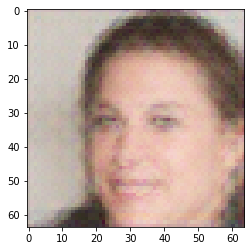

In [58]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
sample = sample.detach().numpy()[0]
sample = sample.transpose((1,2,0))
imgplot = plt.imshow(sample, interpolation='nearest')
plt.show()


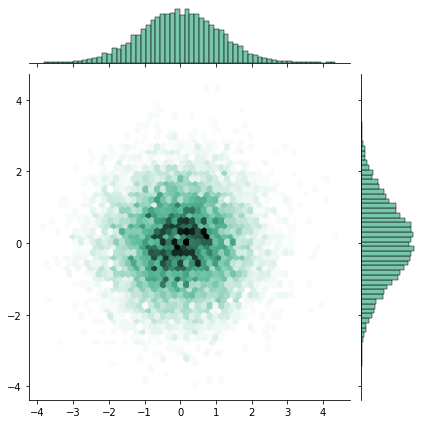

In [59]:
from sklearn.decomposition import PCA
import seaborn as sns

# This already draws random numbers from a GAUSSIAN distribution.
# So we're set...
z = torch.randn(10000, 128).detach().numpy()
pca = PCA(n_components=2)
pcaed_z = pca.fit_transform(z)
sns.jointplot(x=pcaed_z[:, 0], y=pcaed_z[:, 1], kind="hex", color="#4CB391")


# Let's try using my image

In [60]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

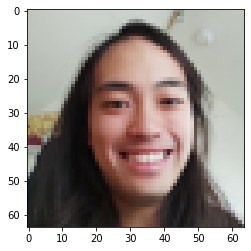

In [61]:
def load_image(img_name):
    img = Image.open(img_name)
 
    width, height = img.size
    min_size = min(width, height)

    # Make the image square & downsample to 64 x 64
    new_size = (min_size, min_size)
    img = img.resize(new_size)
    img = img.resize((64, 64))
    return img

yitong_imgs = [load_image('yitong_faces/big_smile.jpg'),
    load_image('yitong_faces/bigeyes_pucker.jpg'),
    load_image('yitong_faces/bigeyes_surprised.jpg'),
    load_image('yitong_faces/frowning.jpg'),
    load_image('yitong_faces/medium_smile.jpg'),
    load_image('yitong_faces/neutral_smile.jpg'),
    load_image('yitong_faces/tongue.jpg'),
    load_image('yitong_faces/winking.jpg'),
    load_image('yitong_faces/neutral_smile.jpg'),
    ]
# np.stack(
#     [load_image('yitong_faces/big_smile.jpg'),
#     load_image('yitong_faces/bigeyes_pucker.jpg'),
#     load_image('yitong_faces/bigeyes_surprised.jpg'),
#     load_image('yitong_faces/frowning.jpg'),
#     load_image('yitong_faces/medium_smile.jpg'),
#     load_image('yitong_faces/neutral_smile.jpg'),
#     load_image('yitong_faces/tongue.jpg'),
#     load_image('yitong_faces/winking.jpg'),
#     load_image('yitong_faces/neutral_smile.jpg'),
#     ],
#     axis=0
# )
# asarray(
imgplot = plt.imshow(yitong_imgs[0], interpolation='nearest')
plt.show()


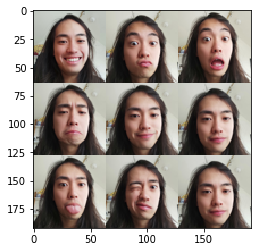

In [62]:
grid = image_grid(yitong_imgs, rows=3, cols=3)
imgplot = plt.imshow(grid, interpolation='nearest')

plt.show()


In [78]:
# Rescale the image tensor to values between 0 and 1 from values 0 to 256
yitong_imgs_tensor = torch.Tensor(np.stack(
    [asarray(img) for img in yitong_imgs],
    axis=0
).transpose(0,3,1,2)) / 256
recons_with_noise = model.generate(yitong_imgs_tensor, current_device='cpu')


model.train()

mu, log_var = model.encode(yitong_imgs_tensor)
# z = model.reparameterize(mu, log_var)
recons = model.decode(mu)


In [72]:
print(recons_with_noise[0,:10])
print(recons)

tensor([[[0.7444, 0.7993, 0.7628,  ..., 0.7666, 0.7680, 0.7172],
         [0.7682, 0.7966, 0.7689,  ..., 0.7694, 0.8046, 0.7823],
         [0.7614, 0.8061, 0.7301,  ..., 0.7482, 0.8197, 0.7779],
         ...,
         [0.1601, 0.1509, 0.1523,  ..., 0.7220, 0.7652, 0.7264],
         [0.2288, 0.1856, 0.1439,  ..., 0.7203, 0.7466, 0.7380],
         [0.2002, 0.1766, 0.1536,  ..., 0.7735, 0.7340, 0.7147]],

        [[0.6842, 0.7188, 0.7092,  ..., 0.7649, 0.7444, 0.6714],
         [0.7275, 0.7622, 0.7620,  ..., 0.8021, 0.8009, 0.7832],
         [0.7375, 0.7870, 0.7561,  ..., 0.7804, 0.8043, 0.7508],
         ...,
         [0.1128, 0.1212, 0.1612,  ..., 0.6696, 0.6645, 0.6577],
         [0.2260, 0.1579, 0.1277,  ..., 0.7241, 0.6844, 0.6473],
         [0.1615, 0.1214, 0.0980,  ..., 0.7697, 0.7003, 0.6669]],

        [[0.6855, 0.7488, 0.7579,  ..., 0.7814, 0.7500, 0.7120],
         [0.7398, 0.7750, 0.7767,  ..., 0.8048, 0.7890, 0.8059],
         [0.7352, 0.7614, 0.7568,  ..., 0.7816, 0.7836, 0.

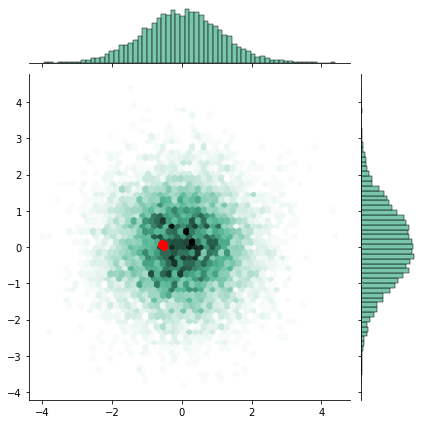

In [73]:
from sklearn.decomposition import PCA
import seaborn as sns

# This already draws random numbers from a GAUSSIAN distribution.
# So we're set...
z_distribution = torch.randn(10000, 128).detach().numpy()
pca = PCA(n_components=2)
pca.fit(z_distribution)
pcaed_z_distrib = pca.transform(z_distribution)
sns.jointplot(x=pcaed_z_distrib[:, 0], y=pcaed_z_distrib[:, 1], kind="hex", color="#4CB391")

pcaed_z = pca.transform(log_var.detach().numpy())
plt.scatter(x=pcaed_z[:, 0], y=pcaed_z[:, 1], color='red')

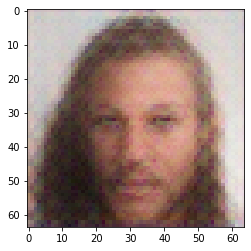

In [74]:
imgplot = plt.imshow(recons[3].detach().numpy().transpose(1,2,0), interpolation='nearest')

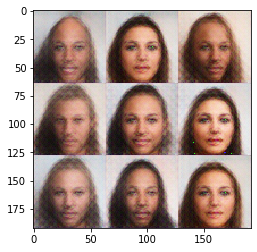

In [79]:
rows, cols = 3,3
imgs_as_arrays = recons_with_noise.detach().numpy().transpose(0,2,3,1)


# assert len(imgs_as_arrays) == rows*cols
imgs_as_arrays = (imgs_as_arrays * 255).astype(np.uint8)
imgs = [Image.fromarray(img_array) for img_array in imgs_as_arrays]


w, h = imgs[0].size
grid = Image.new('RGB', size=(cols*w, rows*h))
grid_w, grid_h = grid.size

for i, img in enumerate(imgs):
    grid.paste(img, box=(i%cols*w, i//cols*h))
imgplot = plt.imshow(grid, interpolation='nearest')

plt.show()
